In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

## Data

In [2]:
sheets = ["st_rev", "oancfy", "xoprq", "FEDFUNDS", "PERMITS", "UEMPLT5", "excess_return"]
d = {s: pd.read_excel("./train_dataset.xlsx", sheet_name=s).drop("conm", axis=1) for s in sheets}
re = d.pop("excess_return").values
val_sheets = ["st_rev", "oancfy", "xoprq", "FEDFUNDS", "PERMITS", "UEMPLT5", "excess_return"]
val_d = {s: pd.read_excel("./validation_dataset.xlsx", sheet_name=s).drop("conm", axis=1) for s in val_sheets}
val_re = val_d.pop("excess_return").values
index_re = pd.read_excel("./index.xlsx", index_col="date")["index_excess_return"]

In [3]:
# normalize data (except returns)
d_stats = {k: (v.values.mean(), v.values.std()) for k, v in d.items()}
d_norm = {k: (v - d_stats[k][0])/d_stats[k][1] for k, v in d.items()}
val_d_stats = {k: (v.values.mean(), v.values.std()) for k, v in val_d.items()}
val_d_norm = {k: (v - d_stats[k][0])/d_stats[k][1] for k, v in val_d.items()}

In [4]:
# estimate factor model of returns (agnostic of time and firm)
X = np.stack([v.values for v in d_norm.values()]).T
val_X = np.stack([v.values for v in val_d_norm.values()]).T
re_tp1 = re.T[1:, :]
val_re_tp1 = val_re.T[1:, :]

## Training

1.917E-05: 100%|██████████| 20000/20000 [01:09<00:00, 288.24it/s]


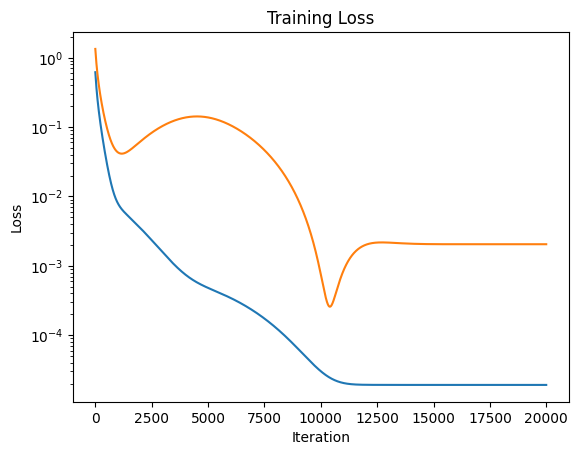

In [5]:
def optimize(l, verbose=True, optimizer=tf.optimizers.legacy.SGD(1e-5)):
    b = tf.Variable(np.random.uniform(size=X[0, 0].shape))
    gamma = tf.Variable(np.random.uniform(size=(1,)))
    optimizer = optimizer
    losses = []
    vlosses = []
    try:
        for _ in (pbar := (tqdm if verbose else lambda x: x)(range(20000))):
            with tf.GradientTape() as tape:
                omega_t = tf.einsum("ijk, k -> ij", X[:-1, :, :], b)
                M_tp1 = 1. - tf.reduce_sum(omega_t * re_tp1[:], axis=1, keepdims=True)/gamma
                loss = tf.reduce_mean(tf.reduce_mean(M_tp1 * (re_tp1[:]), axis=0) ** 2) #tf.reduce_mean(M_tp1 ** 2 * tf.reduce_sum(re_tp1[:] ** 2, axis=1)) + l * tf.reduce_mean((tf.reduce_sum(omega_t, axis=1) - 1.) ** 2)
            gradients = tape.gradient(loss, [b, gamma])
            optimizer.apply_gradients(zip(gradients, [b, gamma]))
            del tape
            if np.isnan(loss.numpy()) or loss.numpy() > 1e12:
                break
            losses.append(loss.numpy())
            vlosses.append(tf.reduce_mean(tf.reduce_mean((1. - tf.reduce_sum(tf.einsum("ijk, k -> ij", val_X[:-1, :, :], b) * val_re_tp1[:], axis=1, keepdims=True)/gamma) * (val_re_tp1[:]), axis=0) ** 2))
            #vlosses.append(tf.reduce_mean((1. - tf.reduce_sum(tf.einsum("ijk, k -> ij", val_X[:-1, :, :], b) * val_re_tp1[:], axis=1, keepdims=True)/gamma) ** 2 * tf.reduce_sum(val_re_tp1[:] ** 2, axis=1)) + l * tf.reduce_mean((tf.reduce_sum(tf.einsum("ijk, k -> ij", val_X[:-1, :, :], b), axis=1) - 1.) ** 2).numpy())
            if verbose:
                pbar.set_description(f"{float(loss.numpy()):.3E}")
    except KeyboardInterrupt:
        pass
    return b, gamma, losses, vlosses

b, gamma, losses, vlosses = optimize(2., optimizer=tf.optimizers.legacy.Adam())
plt.semilogy(losses, label="Adam")
plt.semilogy(vlosses, label="Adam")
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

In [6]:
print(vlosses[-1])

tf.Tensor(0.0020449908967096917, shape=(), dtype=float64)


## Validation and Analysis

In [7]:
print(b.numpy())
print(gamma.numpy())

[-0.09389521 -0.06624388 -0.42340947  0.00782272 -0.01228247  0.01989592]
[0.70696745]


In [8]:
val_omega_t_fit = tf.einsum("ijk, k -> ij", val_X[:-1, :, :], b).numpy()
val_M_tp1_fit = (1. - tf.reduce_sum(val_omega_t_fit * val_re_tp1, axis=1)).numpy()
val_r = np.sum(val_omega_t_fit * val_re_tp1, axis=1)

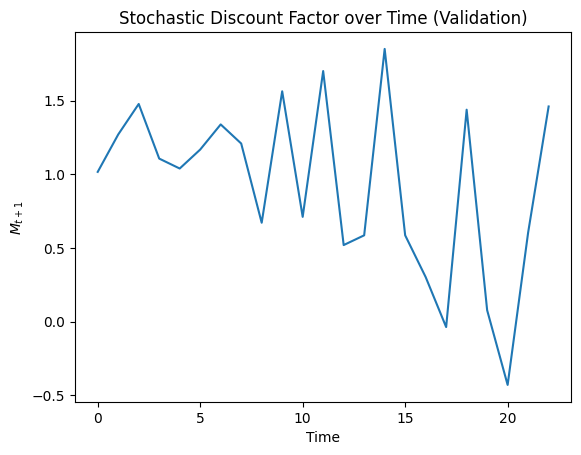

In [9]:
plt.plot(val_M_tp1_fit)
plt.title("Stochastic Discount Factor over Time (Validation)")
plt.ylabel("$M_{t+1}$")
plt.xlabel("Time")
plt.show()

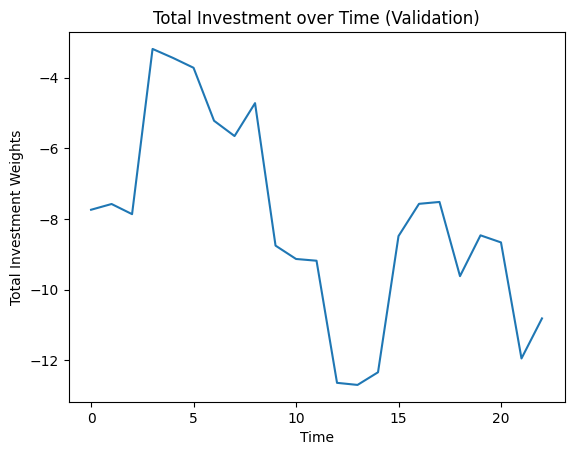

In [10]:
plt.plot(np.sum(val_omega_t_fit, axis=1))
plt.title("Total Investment over Time (Validation)")
plt.ylabel("Total Investment Weights")
plt.xlabel("Time")
plt.show()

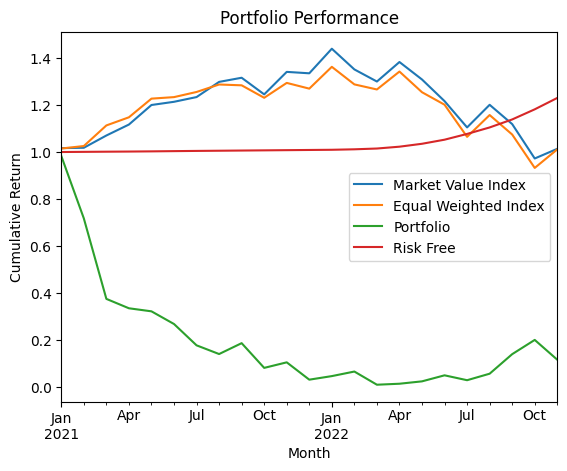

In [11]:
df = pd.read_excel("./index.xlsx").set_index("date").loc[val_d["FEDFUNDS"].columns].iloc[:-1]
df = df.rename({"index_excess_return": "Market Value Index", "equal_weighted_excess_return": "Equal Weighted Index"}, axis=1)
val_df = pd.read_excel("./validation_dataset.xlsx", sheet_name="FEDFUNDS", index_col="conm")
df["Portfolio"] = val_r + 1. + val_d["FEDFUNDS"].values[0, 1:]
df["Risk Free"] = val_d["FEDFUNDS"].values[0, 1:] + 1.
cdf = val_df
(df["Market Value Index"] + 1. + cdf.values[0, :-1]).cumprod().plot()
(df["Equal Weighted Index"] + 1. + cdf.values[0, :-1]).cumprod().plot()
df["Portfolio"].cumprod().plot()
df["Risk Free"].cumprod().plot()
plt.legend()
plt.ylabel("Cumulative Return")
plt.xlabel("Month")
plt.title("Portfolio Performance")
plt.show()

Sharpe Ratio: 0.13238145088874081


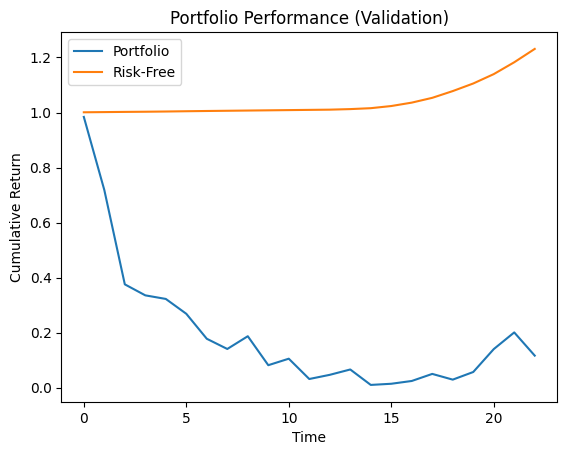

In [12]:
print("Sharpe Ratio:", np.mean(val_r)/np.std(val_r))
plt.plot(np.cumprod(val_r + 1. + val_d["FEDFUNDS"].values[0, 1:]))[-1].set_label("Portfolio")
plt.plot(np.cumprod(val_d["FEDFUNDS"].values[0, 1:] + 1.))[-1].set_label("Risk-Free")
plt.legend()
plt.title("Portfolio Performance (Validation)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()

Sharpe Ratio: 0.1275595328421533


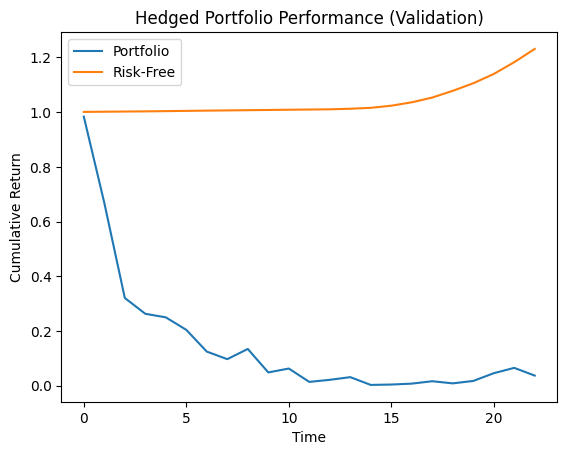

In [13]:
val_r_pair = val_r - index_re.loc[val_d["FEDFUNDS"].columns].values[1:]
print("Sharpe Ratio:", np.mean(val_r_pair)/np.std(val_r_pair))
plt.plot(np.cumprod(val_r_pair + 1. + val_d["FEDFUNDS"].values[0, 1:]))[-1].set_label("Portfolio")
plt.plot(np.cumprod(val_d["FEDFUNDS"].values[0, 1:] + 1.))[-1].set_label("Risk-Free")
plt.legend()
plt.title("Hedged Portfolio Performance (Validation)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()